In [3]:
%load_ext autoreload
%autoreload 2

from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yaml

from dataset.june_dataset import JuNEDataset
from metrics.metrics_time import TimeMetrics


def read_config(config_path: Path = Path("data_config.yaml")) -> dict:
    with config_path.open("r") as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError:
            return {}


config = read_config()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df_hack = pd.read_csv(config.get("dataset_path"), index_col=0)
df_labels = pd.read_csv(config.get("label_mapping_path"), index_col=0)
df_hack = df_hack.merge(df_labels, on='action_id')

df_hack.head()


,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,user_id,expert,cell_label
0,0,2023-05-06 10:32:26.282,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,NaN,NaN,NaN,"[\n {\n ""id"": ""35c0b3b694f84140846a21197ea...",NaN,student_7,False,NaN
1,1,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,NaN,student_7,False,helper_functions
2,2,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions
3,3,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,NaN,student_7,False,helper_functions
4,4,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions


In [5]:
june = JuNEDataset(df_hack)
june.prepare_dataset()
june.df.head()


,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,user_id,expert,cell_label,task
0,0,2023-05-06 10:32:26.282,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,None,None,None,"[\n {\n ""id"": ""35c0b3b694f84140846a21197ea...",None,student_7,False,,task1
1,1,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,None,student_7,False,helper_functions,task1
2,2,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions,task1
3,3,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,None,student_7,False,helper_functions,task1
4,4,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions,task1


In [6]:
TM = TimeMetrics()
metrics = TM.calculate_metrics(june.df)
metrics.head()
kernel_mapping  = metrics.loc[:, ['kernel_id', 'task', 'expert']].drop_duplicates()


In [11]:
sum([len(i) for i in TM.unfinished])

228

# Action time

In [164]:
tr = metrics.next_action_time.quantile(.95)
# TODO recalculate execute time
at_df = metrics.loc[(metrics.next_action_time < tr), :]


In [165]:
def calc_description_stats(df, metrics = ['percent'], stats= ['mean', 'std']):

    cols = list(product(metrics,stats))

    split = df.groupby(['task', 'expert']).describe().loc[:,cols].reset_index()
    expert = df.groupby(['expert']).describe().loc[:,cols].reset_index()
    task = df.groupby(['task']).describe().loc[:,cols].reset_index()
    return pd.concat([split, expert, task])



In [225]:

sum_exec = metrics.groupby('kernel_id').apply(lambda x: x.loc[x.event == 'execute', 'execution_time_sec'].sum()).to_frame('exec_time_sum') / 60
sum_all = metrics.groupby('kernel_id').next_action_time.sum().to_frame('overall_time') / 60
percent = (sum_exec.exec_time_sum / sum_all.overall_time * 100).to_frame('percent').reset_index().merge(metrics[['kernel_id','task','expert']], on='kernel_id', how='left').drop_duplicates()

a = calc_description_stats(at_df, ['next_action_time'],['mean', 'std'])
b = calc_description_stats(metrics, ['execution_time_sec'],['mean', 'std'])
c = calc_description_stats(percent, ['percent'],['mean', 'std'])

merged_stats = a.merge(b, on=['task', 'expert']).merge(c, on=['task', 'expert'])
all = [[np.NaN, np.NaN, at_df.next_action_time.mean(), at_df.next_action_time.std(),
       metrics.execution_time_sec.mean(), metrics.execution_time_sec.std(),
       percent.percent.mean(), percent.percent.std()]]

merged_stats = pd.concat([merged_stats, pd.DataFrame(all, columns=merged_stats.columns)], axis=0).reset_index(drop=True)

pretty_lang = {'task1': 'DA', 'task2': 'ML', np.NaN: 'All',
               False: 'Student', True: 'Professional'}
new_names = ['Task','Level of expertise', 'Time between actions (sec)', 'Time between actions (sec)', 'Execution time (sec)', 'Execution time (sec)', '% of total time', '% of total time']
merged_stats.columns =  pd.MultiIndex.from_tuples([(new_names[i] ,column[1]) for i, column in enumerate(merged_stats.columns.to_list())])
merged_stats = merged_stats.replace(pretty_lang).set_index(['Task', 'Level of expertise']).applymap(lambda x: str.format("{:0_.2f}", x).replace('_', '.'))
merged_stats = merged_stats.loc[merged_stats.index.sort_values(ascending=False)]

/var/folders/4t/jkvqx5j50mx4by8y8jc6539r0000kt/T/ipykernel_97322/3243246238.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_stats = a.merge(b, on=['task', 'expert']).merge(c, on=['task', 'expert'])
/var/folders/4t/jkvqx5j50mx4by8y8jc6539r0000kt/T/ipykernel_97322/3243246238.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_stats = a.merge(b, on=['task', 'expert']).merge(c, on=['task', 'expert'])


In [226]:
print(merged_stats.to_latex(escape=True))

\begin{tabular}{llllllll}
\toprule
 &  & \multicolumn{2}{r}{Time between actions (sec)} & \multicolumn{2}{r}{Execution time (sec)} & \multicolumn{2}{r}{\% of total time} \\
 &  & mean & std & mean & std & mean & std \\
Task & Level of expertise &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{ML} & Student & 14.24 & 22.22 & 7.63 & 50.74 & 11.90 & 9.50 \\
 & Professional & 10.91 & 18.18 & 5.47 & 46.53 & 14.21 & 13.35 \\
 & All & 12.15 & 19.84 & 6.33 & 48.26 & 13.05 & 11.12 \\
\cline{1-8}
\multirow[t]{3}{*}{DA} & Student & 17.16 & 24.77 & 2.95 & 15.81 & 7.60 & 8.48 \\
 & Professional & 19.40 & 25.28 & 1.22 & 9.20 & 2.94 & 2.58 \\
 & All & 17.64 & 24.90 & 2.58 & 14.67 & 6.38 & 7.61 \\
\cline{1-8}
\multirow[t]{3}{*}{All} & Student & 16.48 & 24.24 & 4.05 & 28.26 & 8.89 & 8.78 \\
 & Professional & 13.86 & 21.31 & 3.90 & 37.39 & 9.08 & 11.24 \\
 & All & 15.50 & 23.21 & 3.99 & 31.84 & 8.96 & 9.54 \\
\cline{1-8}
\bottomrule
\end{tabular}


In [55]:
pg.homoscedasticity(data=at_df, dv= 'next_action_time', group='expert')

,W,pval,equal_var
levene,27.830992,1.348489e-07,False


In [56]:
pg.anova(data=at_df, dv= 'next_action_time', between=['task', 'expert'])


,Source,SS,DF,MS,F,p-unc,np2
0,task,6.271275e+04,1.0,62712.750493,118.240495,2.102488e-27,0.010410
1,expert,3.125230e+02,1.0,312.522966,0.589240,4.427292e-01,0.000052
2,task * expert,1.682978e+04,1.0,16829.775497,31.731362,1.812942e-08,0.002815
3,Residual,5.961505e+06,11240.0,530.383015,NaN,NaN,NaN


In [57]:
pg.mwu(at_df.loc[at_df.task == 'task1', 'next_action_time'], at_df.loc[at_df.task != 'task1', 'next_action_time'])

,U-val,alternative,p-val,RBC,CLES
MWU,17059320.5,two-sided,1.144115e-33,-0.135043,0.567521


In [58]:
pg.mwu(at_df.loc[at_df.expert, 'next_action_time'], at_df.loc[~at_df.expert , 'next_action_time'])

,U-val,alternative,p-val,RBC,CLES
MWU,13891440.0,two-sided,2.976797e-08,0.062341,0.468829


In [64]:
sns.set(rc={'figure.figsize':(13.7,6.27)})
def plot_box_time(df, var='next_action_time', label= 'cell_label'):
    my_order = df.groupby(by=[label])[var].mean()
    my_order = my_order.sort_values().index

    sns.boxplot(df, x=label, y =var, order=my_order)

    plt.xticks(rotation=90)


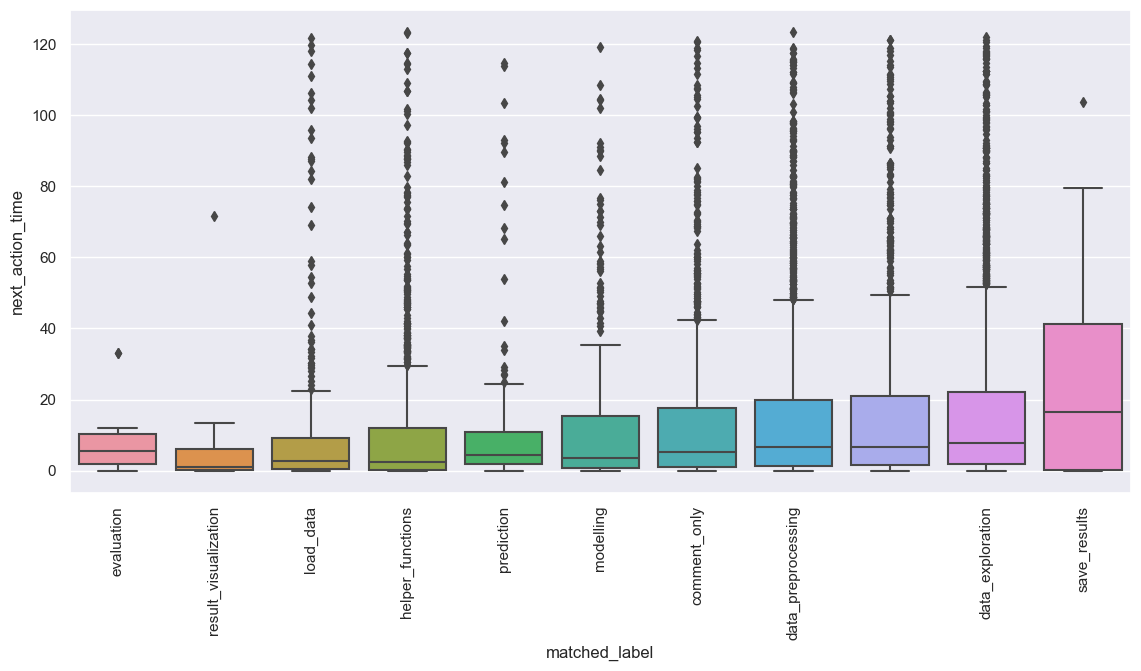

In [65]:
plot_box_time(at_df, label='matched_label')

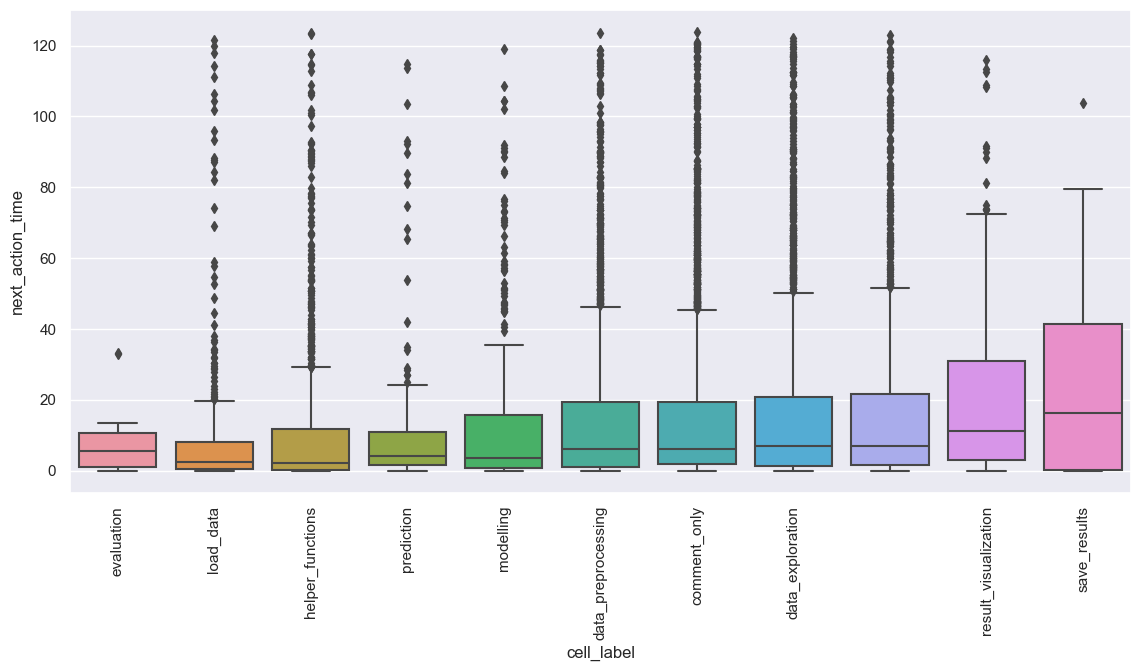

In [66]:
plot_box_time(at_df)

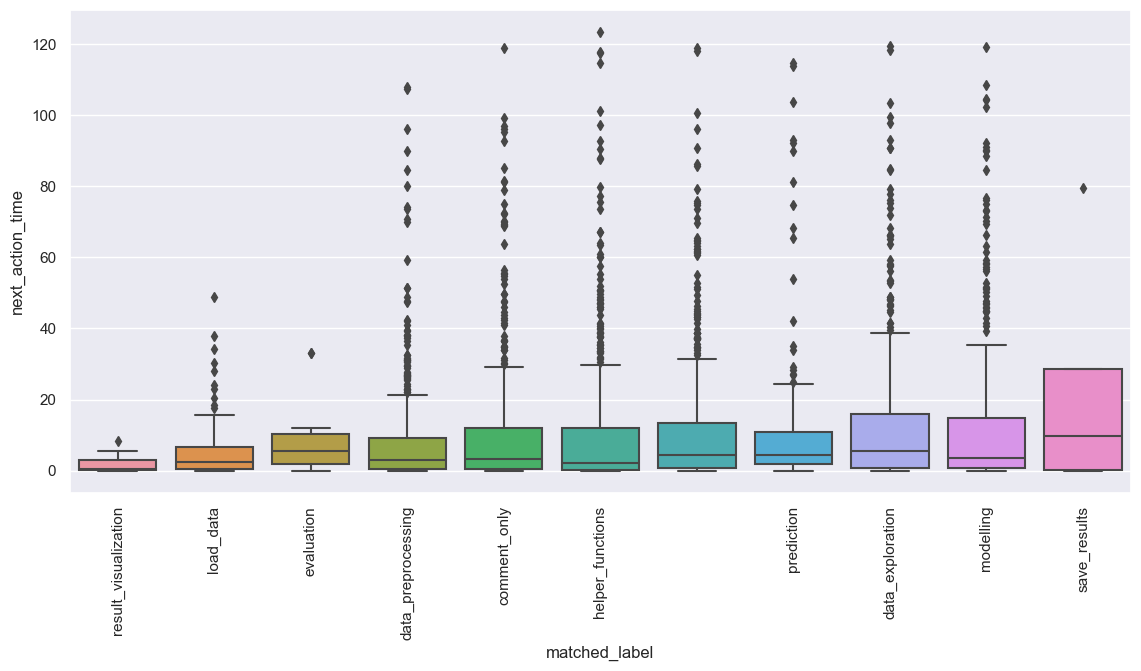

In [67]:
plot_box_time(at_df[at_df.task == 'task2'], label='matched_label')

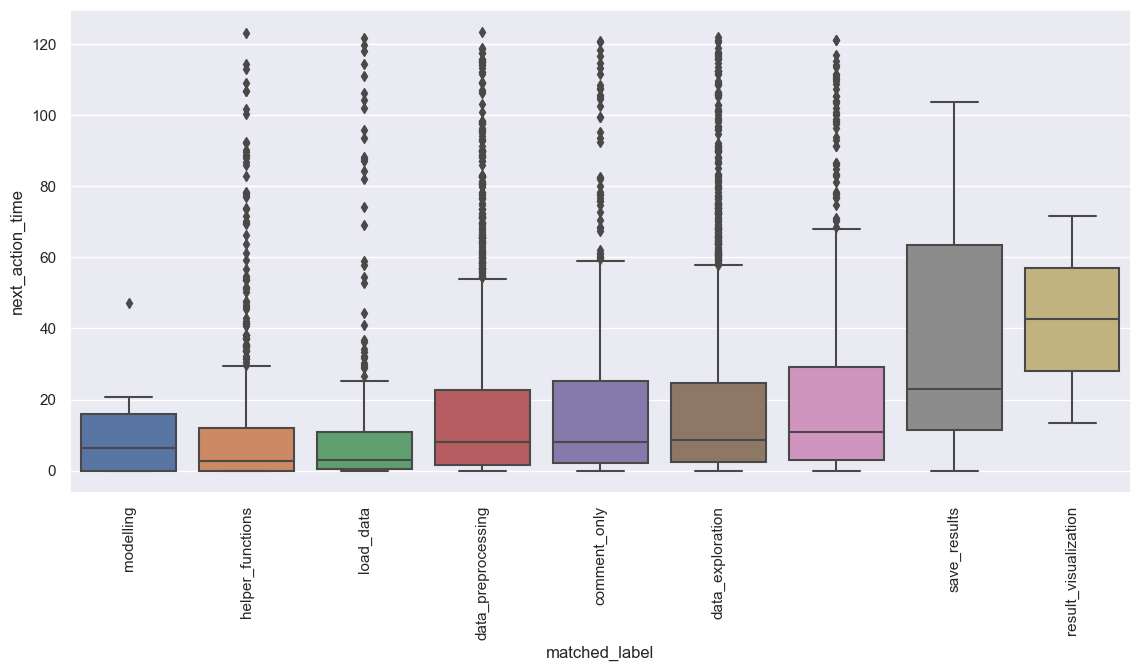

In [68]:
plot_box_time(at_df[at_df.task == 'task1'], label='matched_label')

# Execution time

In [15]:
# TODO:
# deal with missing execs
# metrics.loc[metrics.event == 'execute', ['kernel_id','expert','task', 'state_time_dt']].state_time_dt.isna().sum()

In [178]:
metrics.loc[metrics.event == 'execute', 'cell_index'].nunique(), len(metrics[metrics.event == 'execute'])

(1963, 9207)

In [179]:
execs = metrics.loc[metrics.event == 'execute', ['kernel_id','expert','task', 'execution_time_sec']].dropna()

In [180]:
execs.anova(dv="execution_time_sec", between=["expert", "task"]).round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,expert,6539.547,1.0,6539.547,6.476,0.011,0.001
1,task,36139.237,1.0,36139.237,35.787,0.000,0.004
2,expert * task,80.944,1.0,80.944,0.080,0.777,0.000
3,Residual,9063344.666,8975.0,1009.843,NaN,NaN,NaN


In [212]:
t1_execs_s = execs.loc[((~execs.expert) & (execs.task == 'task1')), 'execution_time_sec']
t1_execs_e = execs.loc[((execs.expert) & (execs.task == 'task1')), 'execution_time_sec']
res = pg.mwu(t1_execs_s, t1_execs_e).round(2)
if res['p-val'][0] >.05:
    print('')

t1_execs_s = execs.loc[((~execs.expert) & (execs.task == 'task2')), 'execution_time_sec']
t1_execs_e = execs.loc[((execs.expert) & (execs.task == 'task2')), 'execution_time_sec']
res = pg.mwu(t1_execs_s, t1_execs_e).round(2)
if res['p-val'][0] >.05:
    print('!!')

t1_execs_s = execs.loc[((execs.expert) & (execs.task == 'task1')), 'execution_time_sec']
t1_execs_e = execs.loc[((execs.expert) & (execs.task == 'task2')), 'execution_time_sec']
res = pg.mwu(t1_execs_s, t1_execs_e).round(2)
if res['p-val'][0] >.05:
    print('!!')

t1_execs_s = execs.loc[((~execs.expert) & (execs.task == 'task1')), 'execution_time_sec']
t1_execs_e = execs.loc[((~execs.expert) & (execs.task == 'task2')), 'execution_time_sec']
res = pg.mwu(t1_execs_s, t1_execs_e).round(2)
if res['p-val'][0] >.05:
    print('!!')

t1_execs_s = execs.loc[execs.task == 'task1', 'execution_time_sec']
t1_execs_e = execs.loc[execs.task == 'task2', 'execution_time_sec']
res = pg.mwu(t1_execs_s, t1_execs_e).round(2)
if res['p-val'][0] >.05:
    print('!!')

t1_execs_s = execs.loc[execs.expert, 'execution_time_sec']
t1_execs_e = execs.loc[~execs.expert, 'execution_time_sec']
res = pg.mwu(t1_execs_s, t1_execs_e).round(2)
if res['p-val'][0] >.05:
    print('!!')


In [213]:
t1_execs_s.mean()

3.8951811976419486

In [216]:
t1_execs_e.mean()

4.050071403752606

In [223]:
t1_execs_s = execs.loc[execs.task == 'task1', 'execution_time_sec']
t1_execs_e = execs.loc[execs.task == 'task2', 'execution_time_sec']
res = pg.mwu(t1_execs_s, t1_execs_e)

In [224]:
res

,U-val,alternative,p-val,RBC,CLES
MWU,10477661.5,two-sided,1.211526e-17,-0.107565,0.553782


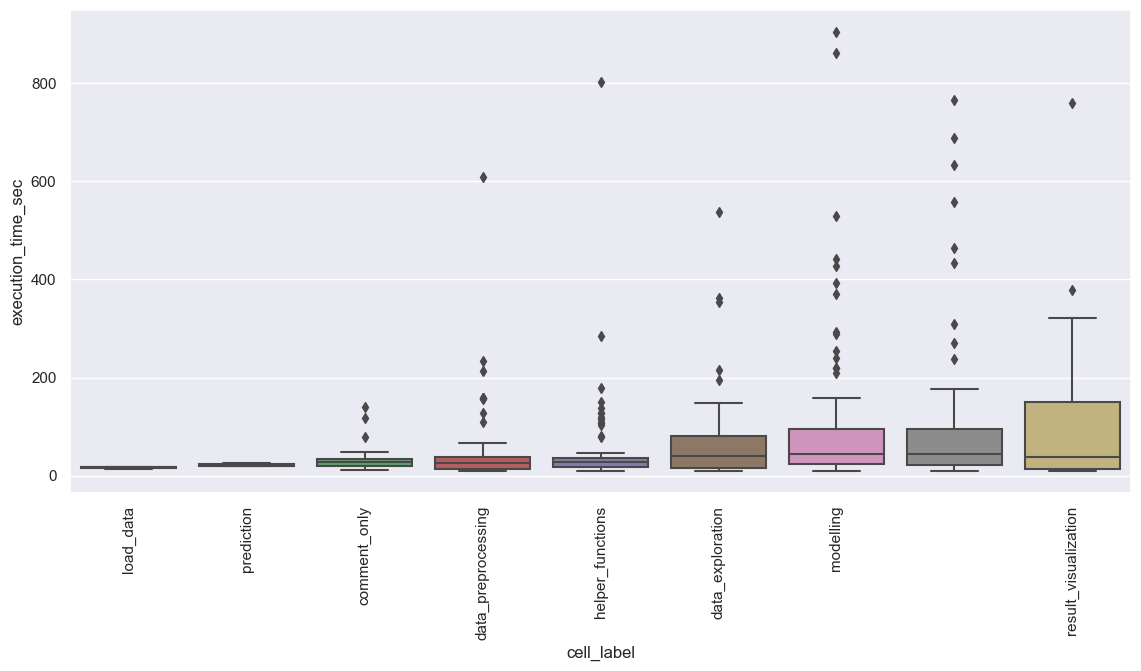

In [184]:
plot_box_time(metrics[metrics.execution_time_sec > 10], var='execution_time_sec')

In [185]:
metrics['scr_len'] = metrics.cell_source.str.len()

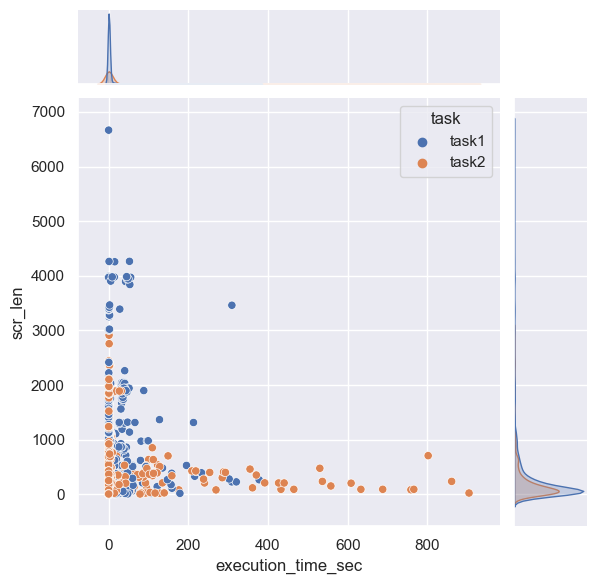

In [186]:
sns.jointplot(metrics[metrics.event == 'execute'], x='execution_time_sec', y='scr_len', hue='task');

In [187]:
pg.corr(metrics[metrics.event == 'execute'].execution_time_sec, metrics[metrics.event == 'execute'].scr_len)

,n,r,CI95%,p-val,BF10,power
pearson,8978,0.058308,"[0.04, 0.08]",3.224604e-08,5.728e+04,0.999822
